### lecture 17 - SARIMAX, Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors

So far the models we've looked at consider past values of a dataset and past errors to determine future trends, seasonality and forecasted values. We look now to models that encompass these non-seasonal (p,d,q) and seasonal (P,D,Q,m) factors, but introduce the idea that external factors (environmental, economic, etc.) can also influence a time series, and be used in forecasting

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose # for ETS Plots
from pmdarima import auto_arima # for determining ARIMA orders
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('./dataset/RestaurantVisitors.csv',index_col='date',parse_dates=True)

In [3]:
df.index.freq = 'D'

For this section we've built a Restaurant Visitors dataset that was inspired by a <a href='https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting'>recent Kaggle competition</a>. The data considers daily visitors to four restaurants located in the United States, subject to American holidays. For the exogenous variable we'll see how holidays affect patronage. The dataset contains 478 days of restaurant data, plus an additional 39 days of holiday data for forecasting purposes.

In [4]:
df.head()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2016-01-01,Friday,1,New Year's Day,65.0,25.0,67.0,139.0,296.0
2016-01-02,Saturday,0,na,24.0,39.0,43.0,85.0,191.0
2016-01-03,Sunday,0,na,24.0,31.0,66.0,81.0,202.0
2016-01-04,Monday,0,na,23.0,18.0,32.0,32.0,105.0
2016-01-05,Tuesday,0,na,2.0,15.0,38.0,43.0,98.0


Notice that even though the restaurant visitor columns contain integer data, they appear as floats. This is because the bottom of the dataframe has 39 rows of NaN data to accommodate the extra holiday data we'll use for forecasting, and pandas won't allow NaN's as integers. We could leave it like this, but since we have to drop NaN values anyway, let's also convert the columns to dtype int64.

In [5]:
df.tail()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2017-05-27,Saturday,0,na,NaN,NaN,NaN,NaN,NaN
2017-05-28,Sunday,0,na,NaN,NaN,NaN,NaN,NaN
2017-05-29,Monday,1,Memorial Day,NaN,NaN,NaN,NaN,NaN
2017-05-30,Tuesday,0,na,NaN,NaN,NaN,NaN,NaN
2017-05-31,Wednesday,0,na,NaN,NaN,NaN,NaN,NaN


In [6]:
df1 = df.dropna()

In [7]:
df1.tail()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2017-04-18,Tuesday,0,na,30.0,30.0,13.0,18.0,91.0
2017-04-19,Wednesday,0,na,20.0,11.0,30.0,18.0,79.0
2017-04-20,Thursday,0,na,22.0,3.0,19.0,46.0,90.0
2017-04-21,Friday,0,na,38.0,53.0,36.0,38.0,165.0
2017-04-22,Saturday,0,na,97.0,20.0,50.0,59.0,226.0


In [8]:
df.columns

Index(['weekday', 'holiday', 'holiday_name', 'rest1', 'rest2', 'rest3',
       'rest4', 'total'],
      dtype='object')

In [9]:
cols = ['rest1','rest2','rest3','rest4','total']

In [10]:
for column in cols:
    df1[column] = df1[column].astype(int)

In [11]:
df1.head()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2016-01-01,Friday,1,New Year's Day,65,25,67,139,296
2016-01-02,Saturday,0,na,24,39,43,85,191
2016-01-03,Sunday,0,na,24,31,66,81,202
2016-01-04,Monday,0,na,23,18,32,32,105
2016-01-05,Tuesday,0,na,2,15,38,43,98


we want to predict and forecast the total number of visitors

<Axes: xlabel='date'>

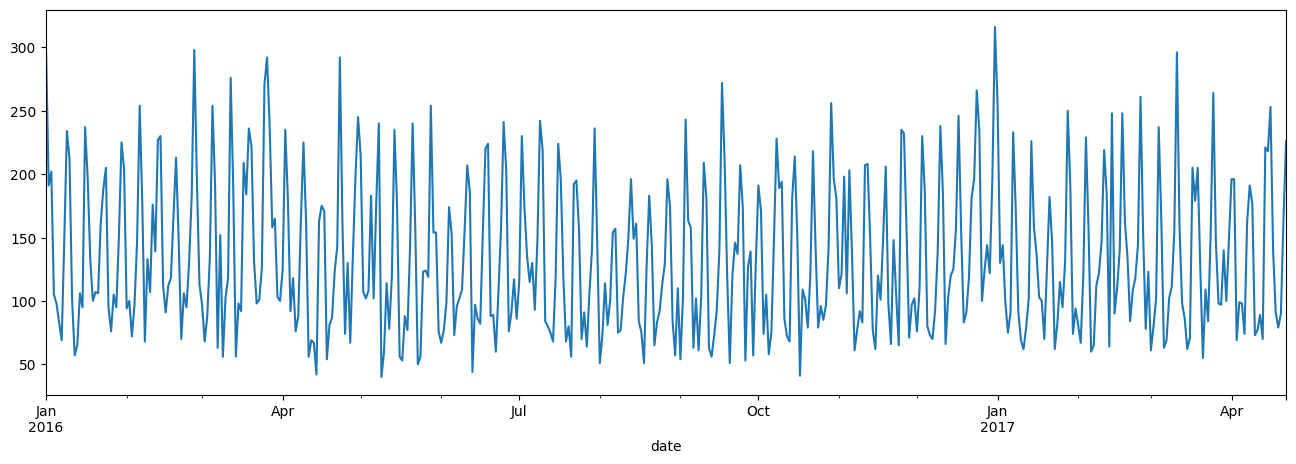

In [12]:
df1['total'].plot(figsize=(16,5))

we can use matplotlib to shade holidays behind our restaurant data

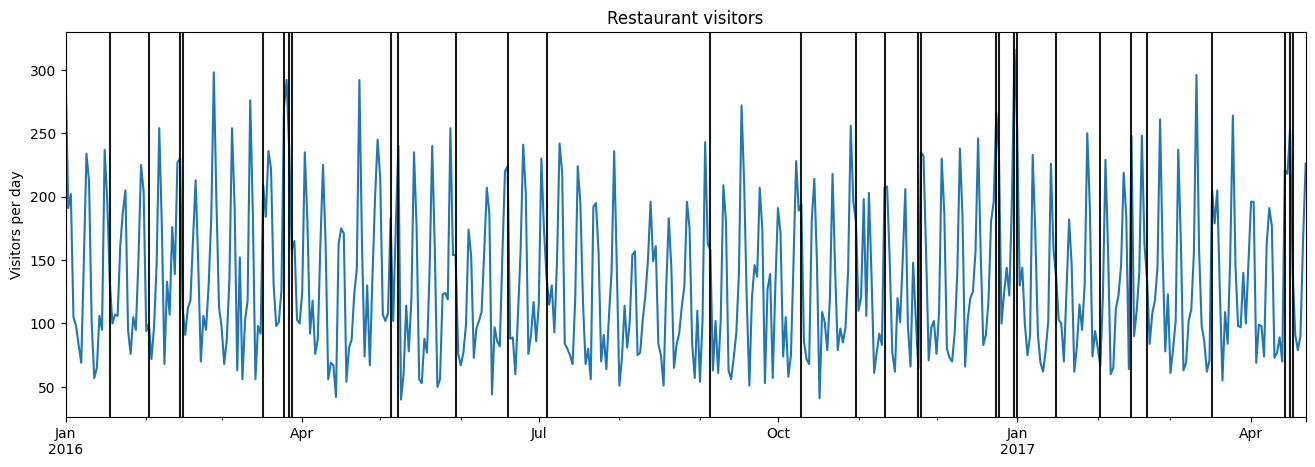

In [13]:
title='Restaurant visitors'
ylabel='Visitors per day'
xlabel='' # we don't really need a label here

ax = df1['total'].plot(figsize=(16,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in df1.query('holiday==1').index: # for days where holiday == 1
    ax.axvline(x=x, color='k', alpha = 0.9); # add a semi-transparent grey line

#### ets decomposition

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [15]:
result = seasonal_decompose(df1['total'])

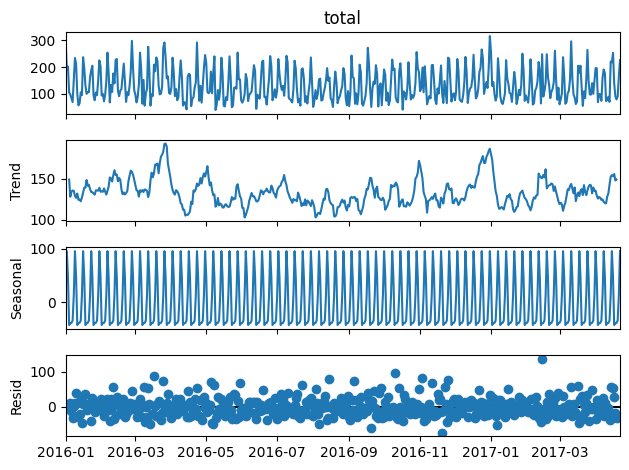

In [16]:
result.plot();

we can see a very strong seasonal component

<Axes: xlabel='date'>

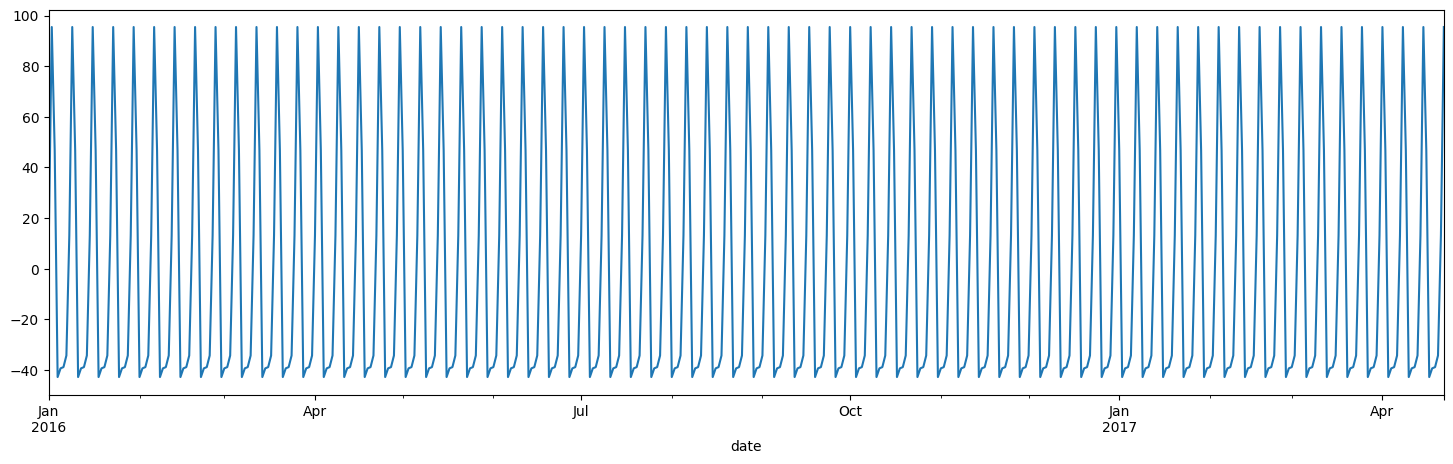

In [17]:
result.seasonal.plot(figsize=(18,5))

so the seasonality of this data set happens to be on a weekly basis, which makes sense since resturants mught have a weekend versus weekday seasonality

#### stationary test

In [18]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [19]:
adf_test(df1['total'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -5.592497
p-value                   0.000001
# lags used              18.000000
# observations          459.000000
critical value (1%)      -3.444677
critical value (5%)      -2.867857
critical value (10%)     -2.570135
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


#### train and test dataset

We'll assign 42 days (6 weeks) to the test set so that it includes several holidays.

In [20]:
len(df1)

478

In [21]:
train = df1.iloc[:436]

In [22]:
test = df1.iloc[436:]

#### auto_arima 

In [23]:
from pmdarima import auto_arima

In [24]:
auto_arima(df1['total'],seasonal=True,m=7).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                 
=================================================================================
Dep. Variable:                         y   No. Observations:                  478
Model:             SARIMAX(1, 0, [1], 7)   Log Likelihood               -2379.422
Date:                   Tue, 31 Dec 2024   AIC                           4766.843
Time:                           10:55:47   BIC                           4783.521
Sample:                       01-01-2016   HQIC                          4773.400
                            - 04-22-2017                                         
Covariance Type:                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.4151      1.404      2.433      0.015       0.663       6.167
ar.S.L7        0.9723      0.011     88.860      0.000       0.951       0.994
ma.S.L7       -0.7874      0.047    -16.821      0.000      -0.879      -0.696
sigma2      1216.0815     71.884     16.917      0.000    1075.192    1356.971
===================================================================================
Ljung-Box (L1) (Q):                  15.43   Jarque-Bera (JB):                72.18
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.85   Skew:                             0.78
Prob(H) (two-sided):                  0.31   Kurtosis:                         4.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### model fit

In [25]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

NOTE: To avoid a <tt>ValueError: non-invertible starting MA parameters found</tt> we're going to set <tt>enforce_invertibility</tt> to False.

In [26]:
model = SARIMAX(train['total'],order=(1,0,0),seasonal_order=(2,0,0,7),
                enforce_invertibility=False)

In [27]:
result = model.fit()

In [28]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             total   No. Observations:                  436
Model:             SARIMAX(1, 0, 0)x(2, 0, 0, 7)   Log Likelihood               -2224.701
Date:                           Tue, 31 Dec 2024   AIC                           4457.403
Time:                                   10:55:47   BIC                           4473.713
Sample:                               01-01-2016   HQIC                          4463.840
                                    - 03-11-2017                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2212      0.047      4.711      0.000       0.129       0.313
ar.S.L7        0.5063      0.036     14.187      0.000       0.436       0.576
ar.S.L14       0.4574      0.037     12.379      0.000       0.385       0.530
sigma2      1520.2899     82.277     18.478      0.000    1359.029    1681.550
===================================================================================
Ljung-Box (L1) (Q):                   0.99   Jarque-Bera (JB):                29.23
Prob(Q):                              0.32   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                             0.34
Prob(H) (two-sided):                  0.37   Kurtosis:                         4.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
start = len(train)

In [30]:
end = len(train) + len(test) - 1

In [31]:
predictions = result.predict(start,end).rename('SARIMA model')

<Axes: xlabel='date'>

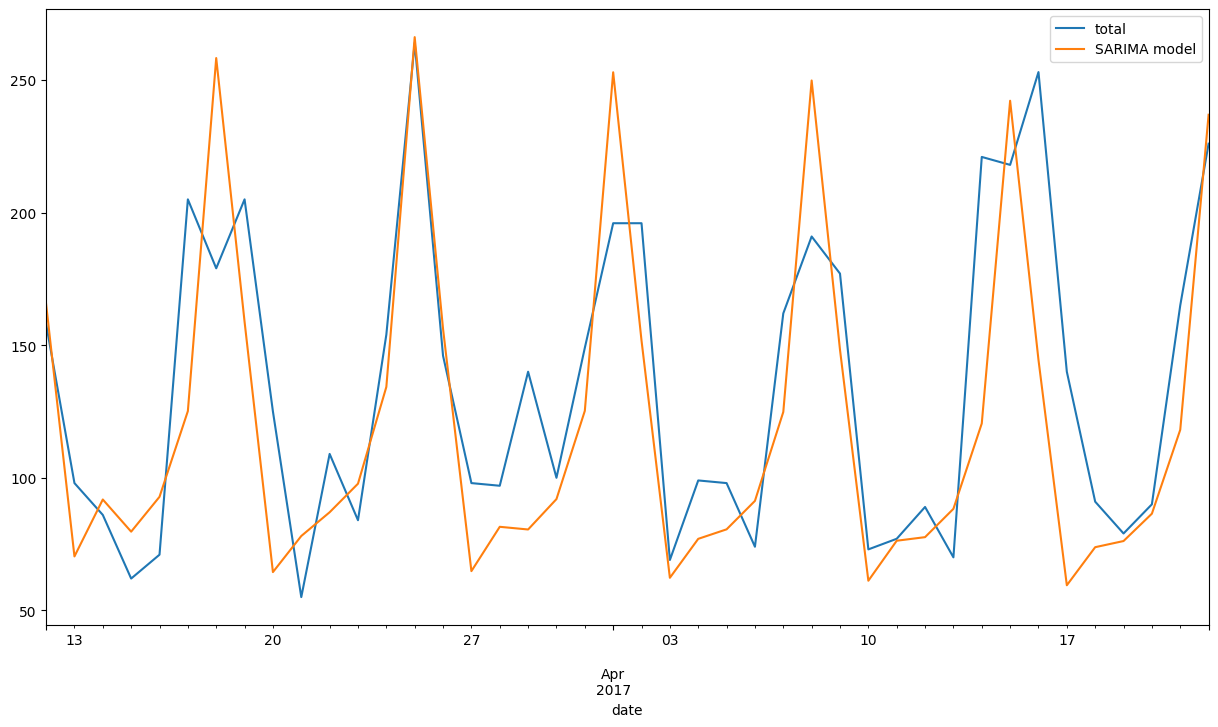

In [32]:
test['total'].plot(legend=True,figsize=(15,8))
predictions.plot(legend=True)

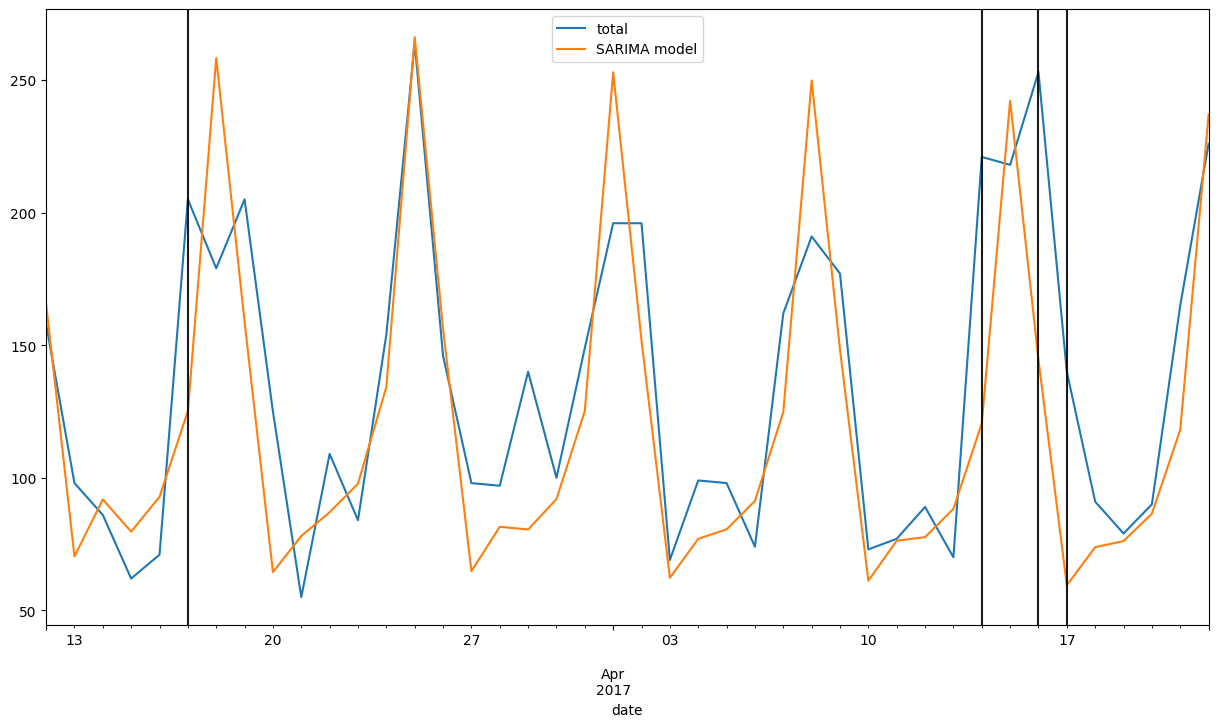

In [33]:
ax = test['total'].plot(legend=True,figsize=(15,8))
predictions.plot(legend=True)

for x in test.query('holiday==1').index: 
    ax.axvline(x=x, color='k', alpha = 0.9); 

so it would be interesting to see if adding in the holidays as exogenous variables would actually improve our model

#### model evaluation

In [34]:
from statsmodels.tools.eval_measures import mse,rmse

error1 = mse(test['total'], predictions)
error2 = rmse(test['total'], predictions)

print(f'SARIMA(1,0,0)(2,0,0,7) MSE Error: {error1:11.10}')
print(f'SARIMA(1,0,0)(2,0,0,7) RMSE Error: {error2:11.10}')

SARIMA(1,0,0)(2,0,0,7) MSE Error: 1702.647954
SARIMA(1,0,0)(2,0,0,7) RMSE Error: 41.26315493


In [37]:
auto_arima(df1['total'],exogenous=df1[['holiday']],seasonal=True,m=7)

ARIMA(order=(0, 0, 0), scoring_args={}, seasonal_order=(1, 0, 1, 7),
      suppress_warnings=True)

#### train our SARIMAX model

In [39]:
model = SARIMAX(train['total'],exog=train[['holiday']],order=(0,0,0),
                seasonal_order=(1,0,1,7),enforce_invertibility=False)

In [40]:
result = model.fit()

In [41]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                 
=================================================================================
Dep. Variable:                     total   No. Observations:                  436
Model:             SARIMAX(1, 0, [1], 7)   Log Likelihood               -2098.580
Date:                   Tue, 31 Dec 2024   AIC                           4205.159
Time:                           10:59:25   BIC                           4221.470
Sample:                       01-01-2016   HQIC                          4211.596
                            - 03-11-2017                                         
Covariance Type:                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday       70.0684      3.972     17.639      0.000      62.283      77.854
ar.S.L7        1.0000   4.72e-05   2.12e+04      0.000       1.000       1.000
ma.S.L7       -1.0463      0.024    -42.751      0.000      -1.094      -0.998
sigma2       739.3351     49.502     14.935      0.000     642.313     836.358
===================================================================================
Ljung-Box (L1) (Q):                  15.36   Jarque-Bera (JB):                21.14
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.01   Skew:                             0.23
Prob(H) (two-sided):                  0.96   Kurtosis:                         3.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [42]:
start = len(train)

In [43]:
end = len(train) + len(test) - 1

In [44]:
predictions = result.predict(start,end,exog=test[['holiday']]).rename('SARIMAX with exog')

<Axes: xlabel='date'>

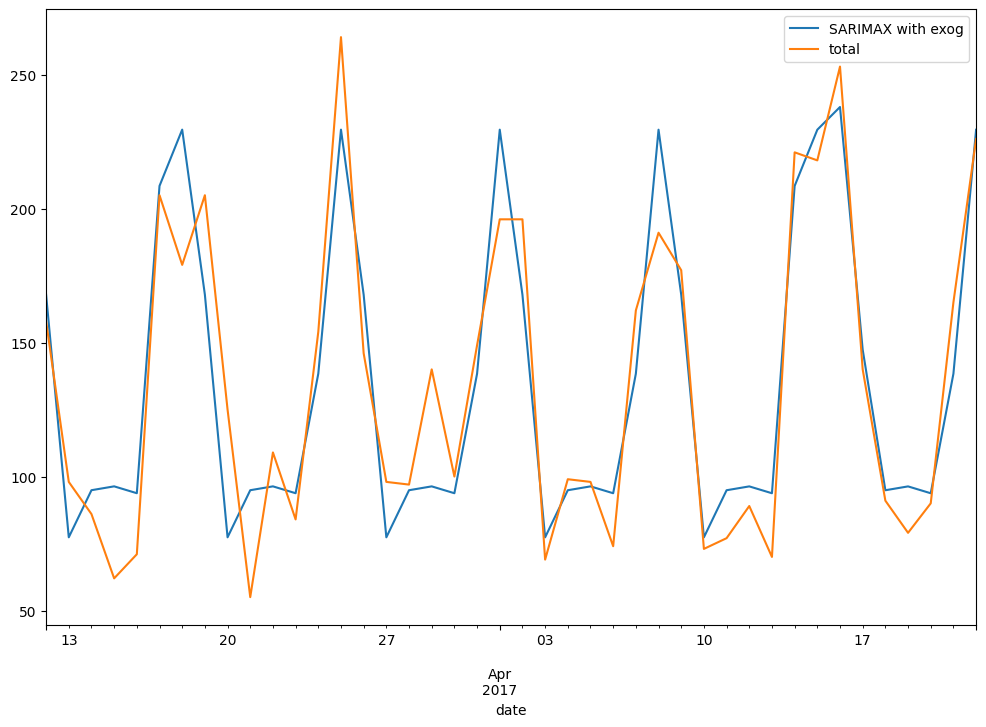

In [45]:
predictions.plot(figsize=(12,8),legend=True)
test['total'].plot(legend=True)

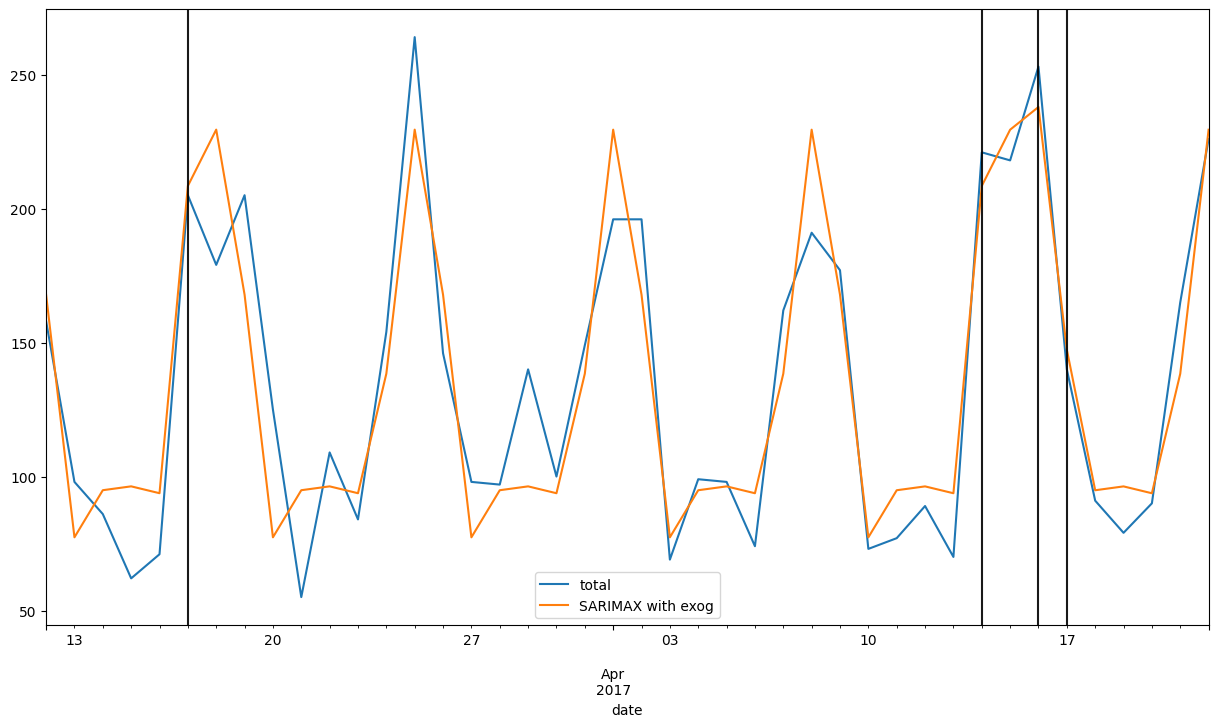

In [46]:
ax = test['total'].plot(legend=True,figsize=(15,8))
predictions.plot(legend=True)

for x in test.query('holiday==1').index: 
    ax.axvline(x=x, color='k', alpha = 0.9); 

We can see that the exogenous variable (holidays) had a positive impact on the forecast by raising predicted values at 3/17, 4/14, 4/16 and 4/17

In [47]:
error1 = mse(test['total'], predictions)
error2 = rmse(test['total'], predictions)

print(f'SARIMAX(0,0,0)(1,0,1,7) MSE Error: {error1:11.10}')
print(f'SARIMAX(0,0,0)(1,0,1,7) RMSE Error: {error2:11.10}')

SARIMAX(0,0,0)(1,0,1,7) MSE Error: 520.3712548
SARIMAX(0,0,0)(1,0,1,7) RMSE Error: 22.81164735


so now the RMSE error is the half of the previous one without the exogenous varibale

#### forecast

We're going to forecast 39 days into the future, and use the additional holiday data

In [49]:
model = SARIMAX(df1['total'],exog=df1[['holiday']],order=(0,0,0),
                seasonal_order=(1,0,1,7),enforce_invertibility=False) 

In [51]:
result = model.fit()

In [52]:
df[478:]

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2017-04-23,Sunday,0,na,NaN,NaN,NaN,NaN,NaN
2017-04-24,Monday,0,na,NaN,NaN,NaN,NaN,NaN
2017-04-25,Tuesday,0,na,NaN,NaN,NaN,NaN,NaN
2017-04-26,Wednesday,0,na,NaN,NaN,NaN,NaN,NaN
2017-04-27,Thursday,0,na,NaN,NaN,NaN,NaN,NaN
2017-04-28,Friday,0,na,NaN,NaN,NaN,NaN,NaN
2017-04-29,Saturday,0,na,NaN,NaN,NaN,NaN,NaN
2017-04-30,Sunday,0,na,NaN,NaN,NaN,NaN,NaN
2017-05-01,Monday,0,na,NaN,NaN,NaN,NaN,NaN


we are going to forecast and fill all this null values from the original dataset

In [53]:
exog_forecast = df[478:][['holiday']]

In [54]:
fcast = result.predict(len(df1),len(df1)+38,exog=exog_forecast).rename('Final SARIMAX forecast')

<Axes: xlabel='date'>

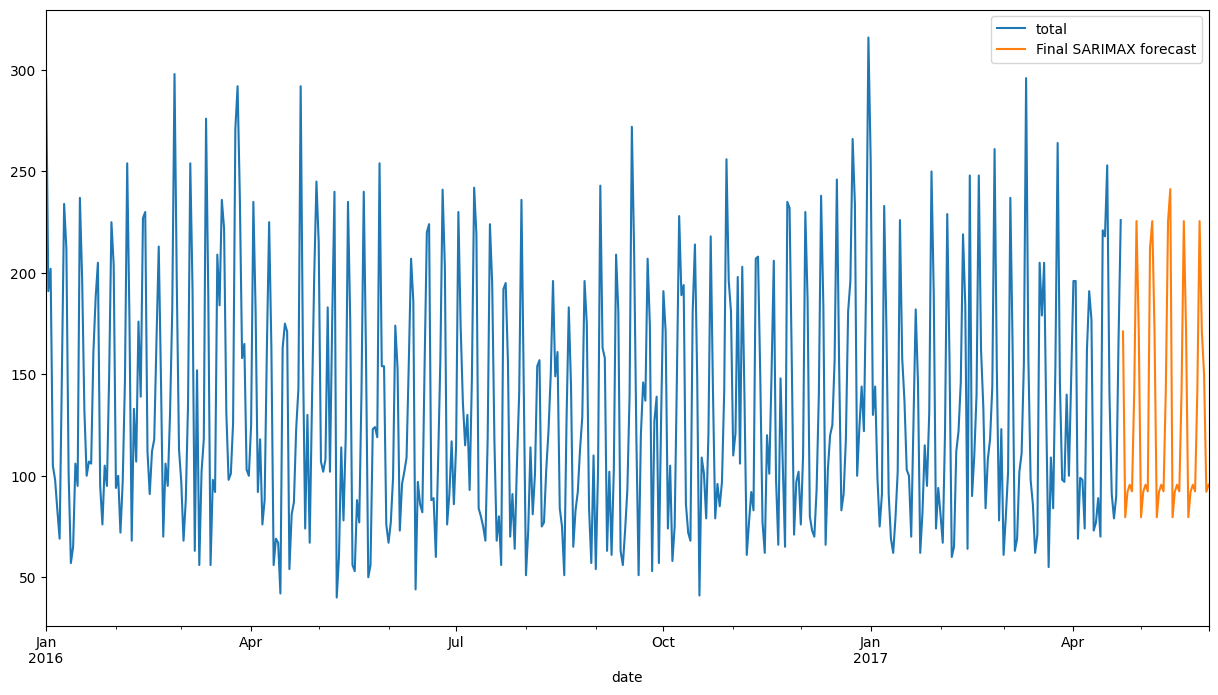

In [55]:
df1['total'].plot(figsize=(15,8),legend=True)
fcast.plot(legend=True)

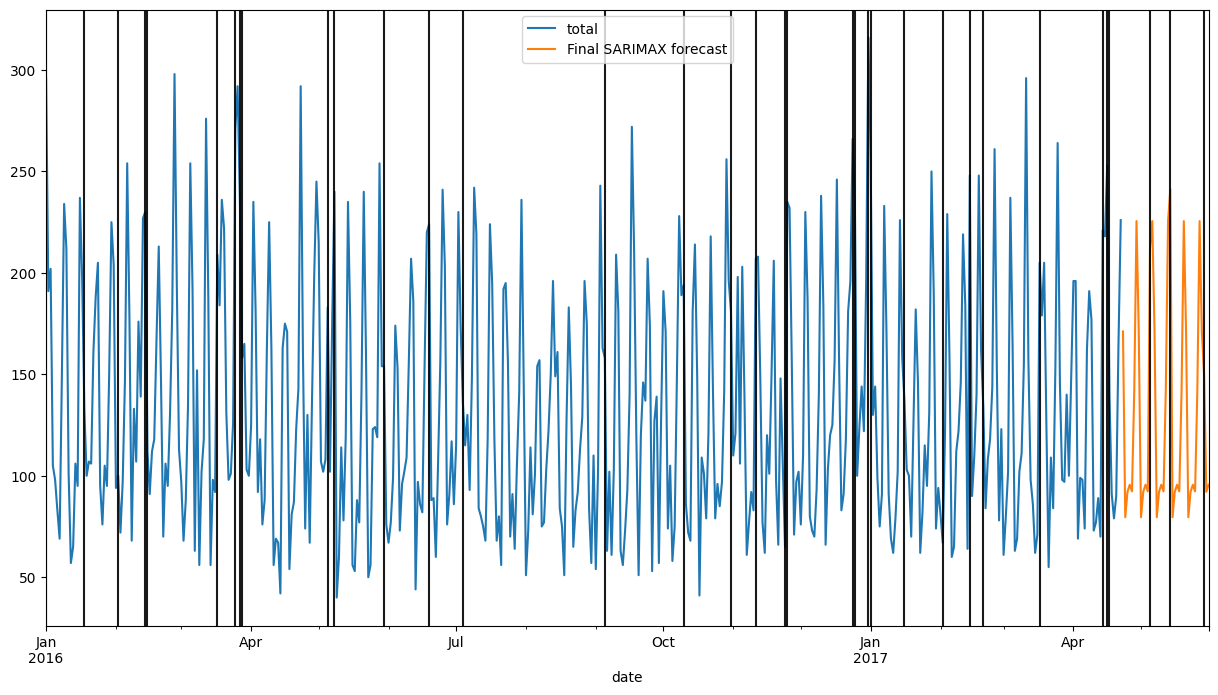

In [57]:
ax = df1['total'].plot(figsize=(15,8),legend=True)
fcast.plot(legend=True)

for x in df.query('holiday==1').index: 
    ax.axvline(x=x, color='k', alpha = 0.9); 

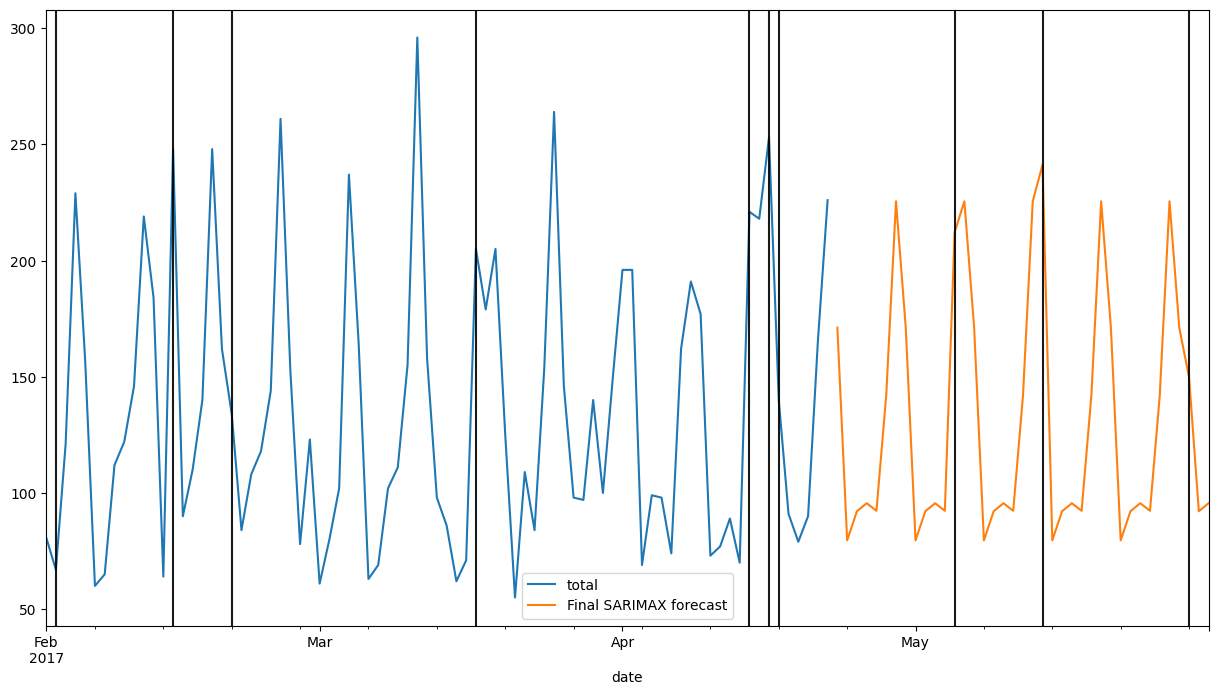

In [59]:
ax = df1['total'].loc['2017-02-01':].plot(figsize=(15,8),legend=True)
fcast.plot(legend=True)

for x in df.query('holiday==1').index: 
    ax.axvline(x=x, color='k', alpha = 0.9); 